In [1]:
# Data Wrangling

import pandas as pd
import sqlite3
import numpy as np

# Get Connection to the DataBase.
con = sqlite3.connect("lahman2014.sqlite")

# Read the Rows in Teams Table into DataFrame.
teams = pd.read_sql_query("SELECT * FROM Teams;", con)

# Read the Rows in Salaries Table into another DataFrame.
salaries = pd.read_sql_query("SELECT * FROM Salaries;", con)

# Close the Connection.
con.close

# Drop all UnNeeded Columns in this Part(part_1).
Neede_cols = ['yearID', 'teamID', 'G', 'W']
teams = teams.loc[:, Neede_cols]

# Now there is No missing Data in Needed Columns from Salaries and Teams Tables .. So the following two lines will not make anything.
salaries.dropna(how='any', inplace=True)
teams.dropna(how='any', inplace=True)

# Calculate the Winning Percentage and Payroll for each Team in each Year.
Percentage = dict()
Payroll = dict()
Years_Avg = dict()
cnt = dict()
for i in range(0, len(teams)):
    # Percentage
    year = teams.iloc[i, 0]
    team = teams.iloc[i, 1]
    games = teams.iloc[i, 2]
    wins = teams.iloc[i, 3]
    try:
        Percentage[team][year] = float(wins / games * 100)
    except:
        Percentage[team] = dict()
        Percentage[team][year] = float(wins / games * 100)

# Payroll
for i in range(0, len(salaries)):
    s_year = salaries.iloc[i, 0]
    s_team = salaries.iloc[i, 1]
    salary = salaries.iloc[i, 4]
    
    try:
        Payroll[s_team][s_year] = float(float(Payroll[s_team][s_year]) + salary)
    except:
        try:
            Payroll[s_team][s_year] = float(salary)
        except:
            Payroll[s_team] = dict()
            Payroll[s_team][s_year] = float(salary)
    
    try:
        Years_Avg[s_year] = Years_Avg[s_year] + salary
        cnt[s_year] = cnt[s_year] + 1
    except:
        Years_Avg[s_year] = salary
        cnt[s_year] = 1



# Payroll and Winning Percentage relation Table Creation.
Team_ID = list()
Year_no = list()
Teams_Pays = list()
Teams_Percentage = list()
for team_id, value1 in Payroll.items():
    for year_no, pays in value1.items():
        Team_ID.append(team_id)
        Year_no.append(year_no)
        Teams_Pays.append(pays)
        try:
            Teams_Percentage.append(Percentage[team_id][year_no])
        except:
            Teams_Percentage.append(np.nan)

for team_id, value1 in Percentage.items():
    for year_no, per in value1.items():
        try:
            tmp = Payroll[team_id][year_no]
        except:
            Team_ID.append(team_id)
            Year_no.append(year_no)
            Teams_Percentage.append(per)
            Teams_Pays.append(np.nan)

# Create Data Frame for the team data in each Year..
team_series = pd.Series(Team_ID)
year_series = pd.Series(Year_no)
team_pays = pd.Series(Teams_Pays)
team_percentage = pd.Series(Teams_Percentage)

Dict = {'TeamID':team_series, 'YearID':year_series, 'Team_Payroll':Teams_Pays, 'Team_winning_Percentage%':Teams_Percentage}
Team_Per_Year = pd.DataFrame(Dict)


# fill the nan values in the table .. i realized that all nan cells are on the payroll column.
# So i will fill each cell with the nearest payroll depending on the winning rate of the previous Years.
for i in range(0, len(Team_Per_Year)):
    tID = Team_Per_Year.iloc[i, 0]
    yearNo = Team_Per_Year.iloc[i, 1]
    t_per = Team_Per_Year.iloc[i, 3]
    if np.isnan(Team_Per_Year.iloc[i, 2]):
        ans = 0
        cntt = 0
        for k, v in Percentage[tID].items():
            try:
                tmp = Payroll[tID][k]
                if tmp == np.nan:
                    continue
                if abs(float(year_no) - float(k)) <= 15:
                    ans = ans + tmp
                    cntt = cntt + 1
            except:
                continue
        if ans != 0:
            Team_Per_Year.iloc[i, 2] = float(ans / cntt)
        if ans == 0:
            x = 0
            y = 0
            for u in range(year_no, year_no + 15):
                try:
                    x = x + Years_Avg[u]
                    y = y + cnt[u]
                except:
                    continue
            for u in range(year_no - 15, year_no):
                try:
                    x = x + Years_Avg[u]
                    y = y + cnt[u]
                except:
                    continue
            Team_Per_Year.iloc[i, 2] = float(x / y)


# there is only 2 nan cells in year 2014 i filled them by the mean of winning percentage of prev 3 years.
for i in range(0, len(Team_Per_Year)):
    if np.isnan(Team_Per_Year.iloc[i, 3]):
        Team_Per_Year.iloc[i, 3] = 40.0


# Description..
'''
1 - First of all i got the connection to the Dataset by using sqlite3 lib in python.
2 - by using select statement query i selected the needed tables from the dataset and i converted it to pandas DataFrame.
3- i calculated the payroll from salaries table for each team in each year by the salary column for each player.
4 - i calculate the winning percentage for each Team in each Year by Teams table by using this columns[G, W, teamID, yearID].
5 - all missing cells are in payroll in some teams in specific year .. so i used the prev and Next 5 years for that team 
    to predict the cur payroll by its mean.
6 - finally, the used cols which will help in analysis part are [teamid, year, games, Wins, salary, winning percentage, payroll]. 
'''
Team_Per_Year

,TeamID,YearID,Team_Payroll,Team_winning_Percentage%
0,ATL,1985,1.480700e+07,40.740741
1,ATL,1986,1.710279e+07,44.720497
2,ATL,1987,1.654456e+07,42.857143
3,ATL,1988,1.272817e+07,33.750000
4,ATL,1989,1.111233e+07,39.130435
5,ATL,1990,1.455550e+07,40.123457
6,ATL,1991,1.840350e+07,58.024691
7,ATL,1992,3.462533e+07,60.493827
8,ATL,1993,4.164142e+07,64.197531
9,ATL,1994,4.938351e+07,59.649123


[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
[443.881193, 613.048418, 805.543323, 901.740134, 927.836287, 951.469367, 956.98355, 1127.285885, 1278.282871, 1494.22875, 1666.135102, 1960.663313, 2024.077522, 2128.262128, 2070.665943, 2188.713398, 2321.472617, 2476.688987, 2684.85867, 2664.726994, 2721.359865, 2784.505291, 2932.741192, 3034.525648, 3192.317623]


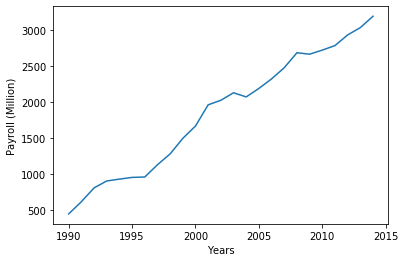

In [3]:
# Exploratory Data Analysis
# 1 - Payroll Distribuations from 1990-2014

# prepare total Payroll of all teams for each Year.
Years_Avg.clear()
cnt.clear()
for i in range(0, len(Team_Per_Year)):
    cur_year = Team_Per_Year.iloc[i, 1]
    cur_pay = Team_Per_Year.iloc[i, 2]
    try:
        Years_Avg[cur_year] = Years_Avg[cur_year] + cur_pay
        cnt[cur_year] = cnt[cur_year] + 1
    except:
        Years_Avg[cur_year] = cur_pay
        cnt[cur_year] = 1

# Target the Period from 1990 --> 2014.
x_years = []
y_pay = []
for key, value in Years_Avg.items():
    if key >= 1990 and key <= 2014:
        x_years.append(key)
        y_pay.append(value / 1000000)


print(x_years)
print(y_pay)

# Plot the Distribution between the Years and Payrolls across all teams.
import matplotlib.pyplot as plt
plt.plot(x_years, y_pay)
plt.xlabel('Years')
plt.ylabel('Payroll (Million)')

# Description..
"""
'i ploted all possible plots for each team in each year.
 but the following plot is the overall payroll for all team in each year form 1990 to 2014'
1 - first of all, i Got the total payroll for all teams in each Year.
2 - then using matplotlib i plot the Distribution between years and total payroll in this year.
3 - the figure shows that Almost the Payroll increases by increasing the Years also
    Every five years i notice that the rate of payroll decreases by some ratio then increases again.
4 - from the start of 1990 to the end of 2014 there are about 2500 million increases to the total payroll across all treams.
"""

plt.show()

[19.0682526224462, 56.46067775266855, 60.07085328434262, 75.02415820618567, 56.80349103611336]
[47.799438987827536, 49.30228192805907, 49.63188452253876, 49.90921908318292, 49.96025867118365]


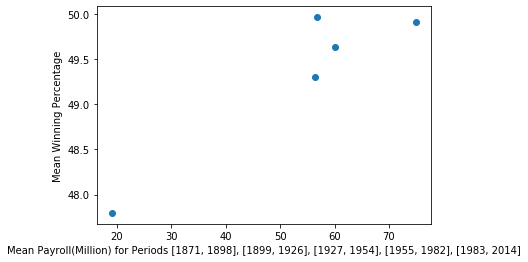

In [4]:
# 2- Correlation between payroll and winning percentage ..

# Prepare total winning Percentage of all team for each Year.
Percentage_avg = dict()
cnt1 = dict()
for i in range(0, len(Team_Per_Year)):
    cur_year = Team_Per_Year.iloc[i, 1]
    cur_per = Team_Per_Year.iloc[i, 3]
    try:
        Percentage_avg[cur_year] = Percentage_avg[cur_year] + cur_per
        cnt1[cur_year] = cnt1[cur_year] + 1
    except:
        Percentage_avg[cur_year] = cur_per
        cnt1[cur_year] = 1

# Divide Years into 5 time Periods..
x_axis = []
y_axis = []
start = 1871
for i in range(0, 5):
    end = start + 28
    if i == 4:
        end = 2015
    sums_pay = 0
    cnts_pay = 0
    sums_per = 0
    cnts_per = 0
    for j in range(start, end):
        sums_pay = sums_pay + (Years_Avg[j] / 1000000)
        cnts_pay = cnts_pay + cnt[j]
        sums_per = sums_per + Percentage_avg[j]
        cnts_per = cnts_per + cnt1[j]
    x_axis.append(float(sums_pay / cnts_pay))
    y_axis.append(float(sums_per / cnts_per))
    start = end

print(x_axis)
print(y_axis)

plt.scatter(x_axis, y_axis)
plt.xlabel('Mean Payroll(Million) for Periods [1871, 1898], [1899, 1926], [1927, 1954], [1955, 1982], [1983, 2014]')
plt.ylabel('Mean Winning Percentage')

# Description..
'''
1 - first of all i divided the Years into 5 periods [1871, 1898], [1899, 1926], [1927, 1954], [1955, 1982], [1983, 2014].
2 - then for each period i calculated the mean of the winning percentage and payroll.
3 - i ploted the relation between mean percentage and mean payroll for each period.
4 - So i realized that the Central tendency is in mean payroll about 60%
    and almost if the mean of Payroll increases the winning percentage is increases.
'''

# So there are teams are good at paying and winning percentage .. almost there are the teams are in years from 1899 to 1926
  #they have good avg at ther payroll with good winning percentage average.
# the effiency are if the mean of payroll increases the winning percentage increases except the central tendency of mean payroll 
    # ~=60%.

plt.show()

C:\Users\m\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


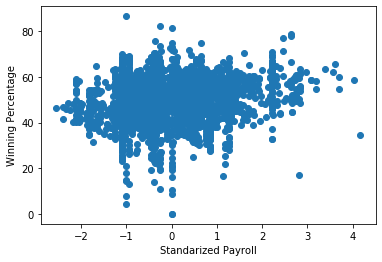

In [5]:
# Data Transformations
# 1- Standardizing payroll


import math

standard = dict()
for i in range(0, len(Team_Per_Year)):
    st_year = Team_Per_Year.iloc[i, 1]
    st_pay = Team_Per_Year.iloc[i, 2]
    st_sum = Years_Avg[st_year]
    st_N = cnt[st_year]
    st_mean = float(st_sum / st_N)
    try:
        standard[st_year] = standard[st_year] + (math.pow((st_pay - st_mean),2))
    except:
        standard[st_year] = math.pow((st_pay - st_mean),2)

x_axis.clear()
y_axis.clear()
for i in range(0, len(Team_Per_Year)):
    st_year = Team_Per_Year.iloc[i, 1]
    st_pay = Team_Per_Year.iloc[i, 2]
    st_sum = Years_Avg[st_year]
    st_N = cnt[st_year]
    st_mean = float(st_sum / st_N)
    if np.isnan(st_pay):
        print(1)
    stand =  math.sqrt(float(standard[st_year] / st_N))
    
    Team_Per_Year.iloc[i, 2] = float((st_pay - st_mean) / stand)
    if np.isnan(Team_Per_Year.iloc[i, 2]):
        Team_Per_Year.iloc[i, 2] = 0.0
    x_axis.append(Team_Per_Year.iloc[i, 2])
    y_axis.append(Team_Per_Year.iloc[i, 3])


plt.scatter(x_axis, y_axis)
plt.xlabel('Standarized Payroll')
plt.ylabel('Winning Percentage')

# Description..
'''
1 - first of all, i get the varience for each Year depending on the payroll to get the standard div
2 - i applied the given formula to standarize the payroll for each year.
3 - i plot the relation between the standarized payroll and winning percentage
    # to fit the best regression line across this relation.
'''


plt.show()

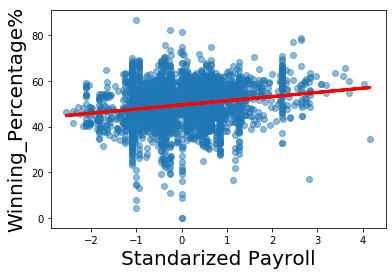

,Actual_Winning_Percentage,Predicted_Winning_Percentage
0,40.740741,54.882069
1,44.720497,54.209691
2,42.857143,54.015320
3,33.750000,50.882613
4,39.130435,48.047132
5,40.123457,48.298775
6,58.024691,48.086284
7,60.493827,51.014971
8,64.197531,52.602109
9,59.649123,54.849664


In [6]:
# 2- Expected wins

from sklearn import linear_model

# Get X, Y 
X = Team_Per_Year['Team_Payroll']
Y = Team_Per_Year['Team_winning_Percentage%']
X = np.expand_dims(X, axis=1)
Y = np.expand_dims(Y, axis=1)

# Model Creation.
model = linear_model.LinearRegression()
model.fit(X, Y)

# y = mx + c --> get m,c
c = model.coef_
f = model.intercept_

# Get the Best Regression Line..
plt.figure('Regression Line')
plt.scatter(X, Y, alpha=0.5)
plt.xlabel('Standarized Payroll', fontsize=20)
plt.ylabel('Winning_Percentage%', fontsize=20)
pre = c[0][0] * X + f[0]
plt.plot(X, pre, color='red', linewidth=3)
plt.show()

# Prediction using eq = 50 + 2.5 * stand_pay
Actual_win = []
Predicted_win = []
for i in range(0, len(Team_Per_Year)):
    Actual_win.append(Team_Per_Year.iloc[i, 3])
    Predicted_win.append(50 + (2.5 * Team_Per_Year.iloc[i, 2]))

actual_series = pd.Series(Actual_win)
predicted_series = pd.Series(Predicted_win)

D = {'Actual_Winning_Percentage':actual_series, 'Predicted_Winning_Percentage':predicted_series}
predictions = pd.DataFrame(D)

# Description
'''
1 - first of all, i got the standarized payroll as x_axis and win_percentage as y_axis
2 - create linear regression model to fit that data.
3 - get the coff and intercept to draw the line.
4 - predict the win_percentage by the given equation.

'''


predictions

In [7]:
# 3- Spending efficiency.

Effiency = []
for i in range(len(predictions)):
    actual = predictions.iloc[i, 0]
    pred = predictions.iloc[i, 1]
    Effiency.append(float(actual - pred))

Effiency_series = pd.Series(Effiency)

D = {'Efficiency':Effiency_series}
D = pd.DataFrame(D)

# Description..
'''
1 - First of all, i Calculated the efficiency by the given equation.
2 - i realized that that max difference between the actual and predicted winning percentage is 15.
    and the min diff is 0.7 so the Oakland's efficiency is about to be good in average. 
'''

D

,Efficiency
0,-14.141329
1,-9.489194
2,-11.158177
3,-17.132613
4,-8.916698
5,-8.175318
6,9.938408
7,9.478856
8,11.595422
9,4.799458
